<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    int64  
 12  FamilySize   891 non-null    int64  
 13  Title        891 non-null    object 
dtypes: float64(2), int64(7), object(5)
memory usage: 97.6+ KB
{'subsample': 0.75, 'reg_alpha': 0.05, 'n_estimators': 900, 'min_child_weight': 5, 'max_depth': 9, 'gamma': 0.3, 'eta': 0.01, 'colsample_bytree': 0.75}
Train ac

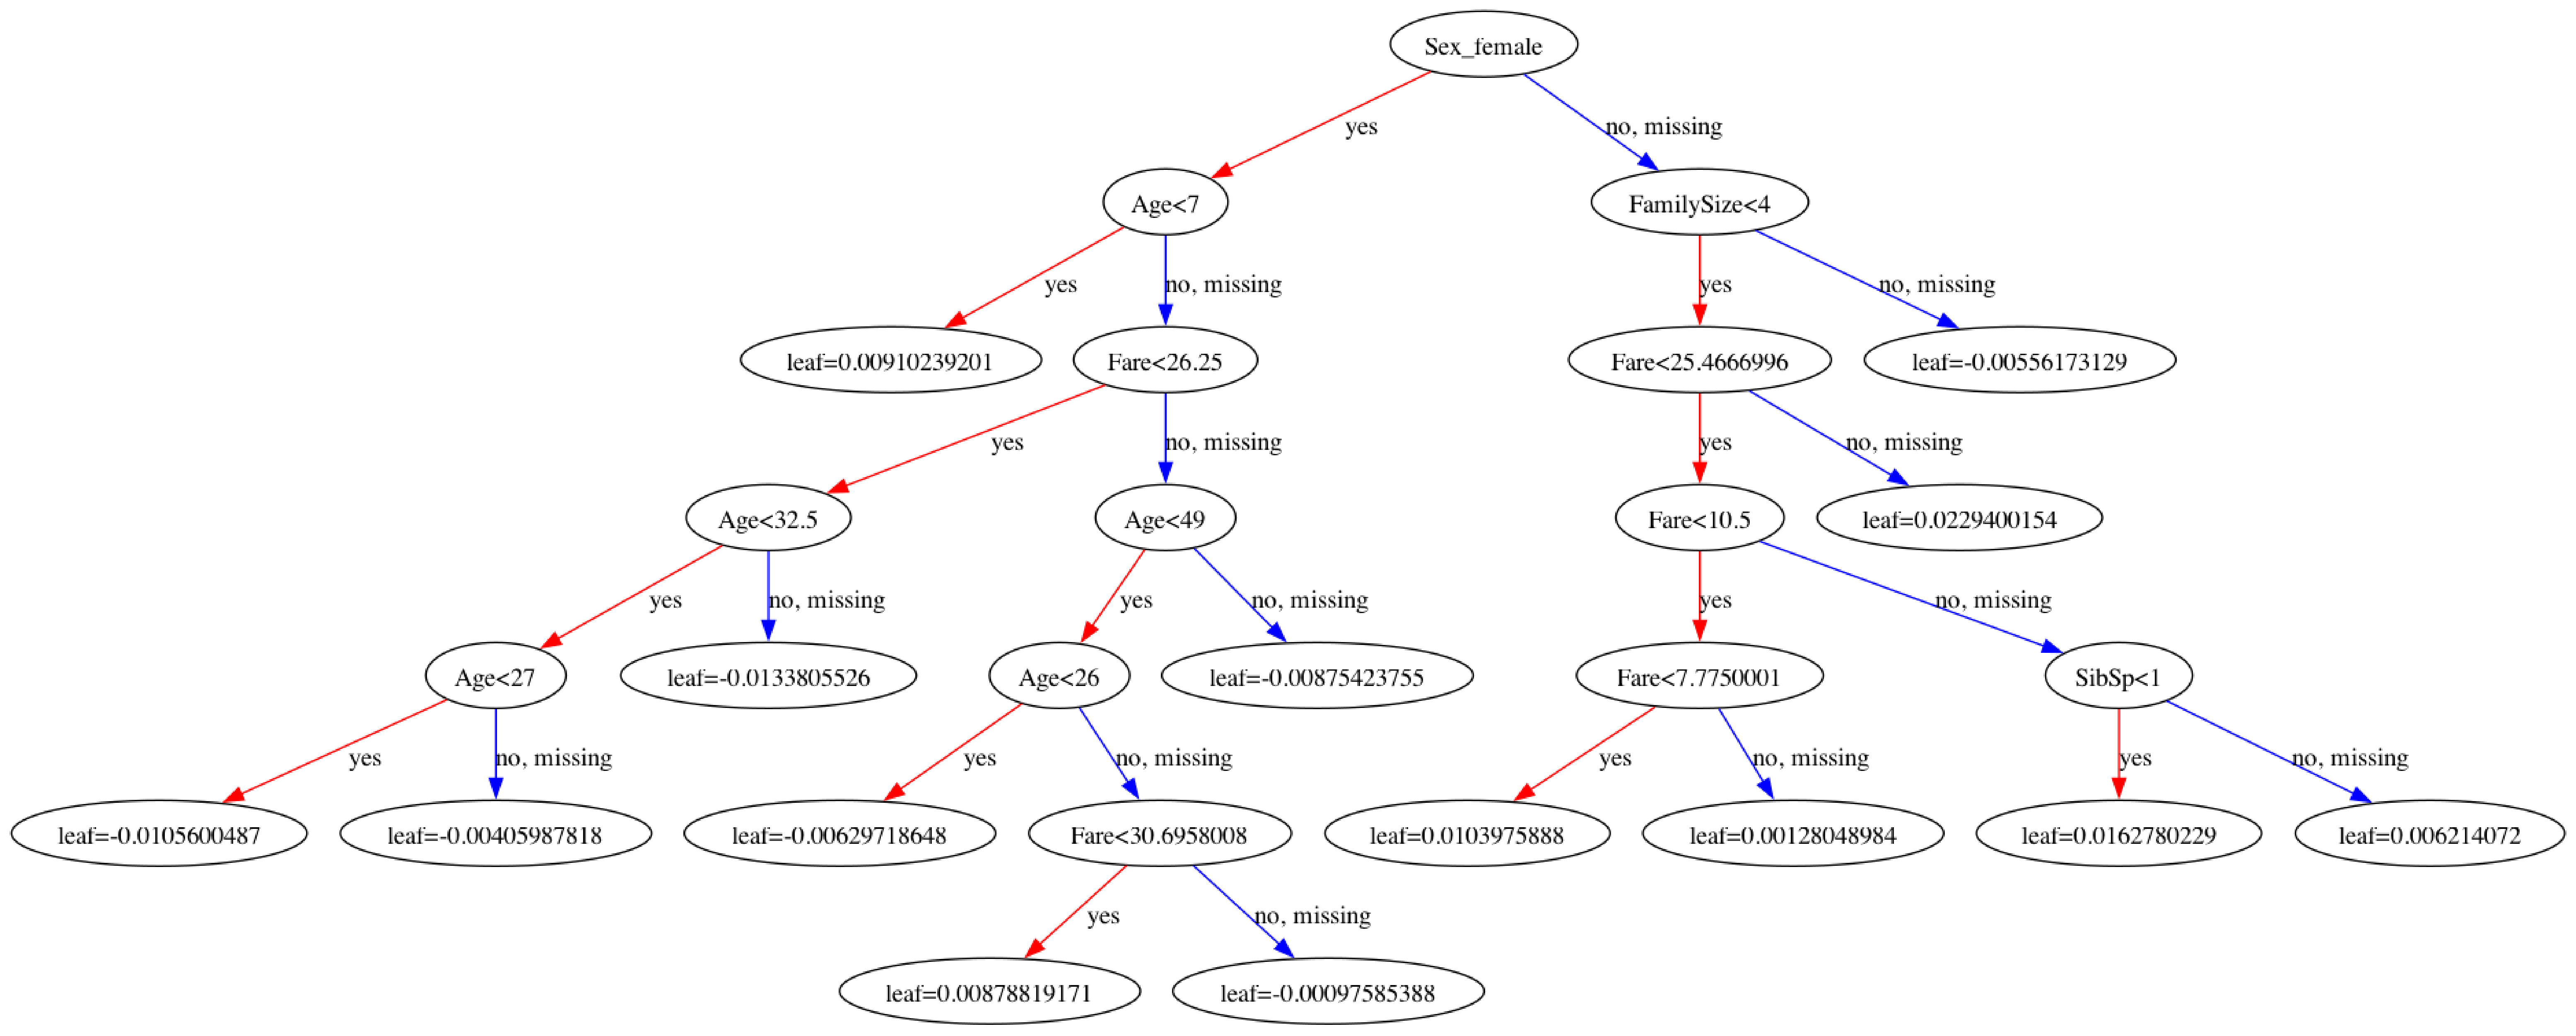

In [26]:
import pandas as pd
import xgboost as xgb
from xgboost import plot_tree
from sklearn.metrics import accuracy_score
from matplotlib.pylab import rcParams
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import numpy as np

def feature_engineer(data):
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace = True)
    data['Embarked'] = data['Embarked'].map( {'Q': 0, 'S': 1, 'C': 2} ).astype(int)
    data['FamilySize'] = data['SibSp'] + data['Parch']
    eng_title(data)
    eng_age(data)
    # data['SES'] = data['Pclass'] * data['Fare']
    # age_imp = SimpleImputer(strategy="median")
    # data['Age'] = age_imp.fit_transform(data[['Age']])
    # data.dropna(subset=['Age'], inplace=True)
    # data["Cabin"] = data["Cabin"].isna()

# https://www.kaggle.com/code/nicapotato/titanic-feature-engineering
def eng_title(data):
    data['Title']=0
    data['Title']=data.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    data['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Dona','Jonkheer','Col',
                         'Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
    
def eng_age(data):
    data.loc[(data.Age.isnull())&(data.Title=='Mr'),'Age']= data.Age[data.Title=="Mr"].mean()
    data.loc[(data.Age.isnull())&(data.Title=='Mrs'),'Age']= data.Age[data.Title=="Mrs"].mean()
    data.loc[(data.Age.isnull())&(data.Title=='Master'),'Age']= data.Age[data.Title=="Master"].mean()
    data.loc[(data.Age.isnull())&(data.Title=='Miss'),'Age']= data.Age[data.Title=="Miss"].mean()
    data.loc[(data.Age.isnull())&(data.Title=='Other'),'Age']= data.Age[data.Title=="Other"].mean()

train_data = pd.read_csv('train.csv')
feature_engineer(train_data)

train_data.info()

test_data = pd.read_csv('test.csv')
feature_engineer(test_data)

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'FamilySize', 'Fare', 'Embarked']

X_train = train_data[features]
y_train = train_data['Survived']

X_test = test_data[features]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

param_distributions = {
    'eta': [x for x in np.linspace(start=0.01, stop=0.2, num=4)],
    'max_depth': range(1,10,1),
    'min_child_weight': range(1,13,2),
    'n_estimators': [600,900,1200,1500],
    'gamma': [i/10.0 for i in range (0,5)],
    'subsample': [i/100.0 for i in range (60, 100, 5)],
    'colsample_bytree': [i/100.0 for i in range (60, 100, 5)],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
}

model = xgb.XGBClassifier(random_state=1)

clf = RandomizedSearchCV(model, param_distributions=param_distributions, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
best_model = clf.best_estimator_

y_train_pred = best_model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train accuracy: " + str(train_accuracy))

rcParams['figure.figsize'] = 80,50
plot_tree(best_model, fontsize=12)

predictions = best_model.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)





